In [41]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, classification_report
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers  # <-- ADD THIS
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pickle
import os
from datetime import datetime

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

TensorFlow version: 2.20.0
GPU Available: False


In [42]:
# DATA ACQUISITION

print("=" * 60)
print("DATA ACQUISITION")
print("=" * 60)

# Load CIFAR-10 dataset (automatically downloads if not present)
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"\nTraining data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"\nNumber of classes: {len(class_names)}")
print(f"Class names: {class_names}")

DATA ACQUISITION

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)

Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


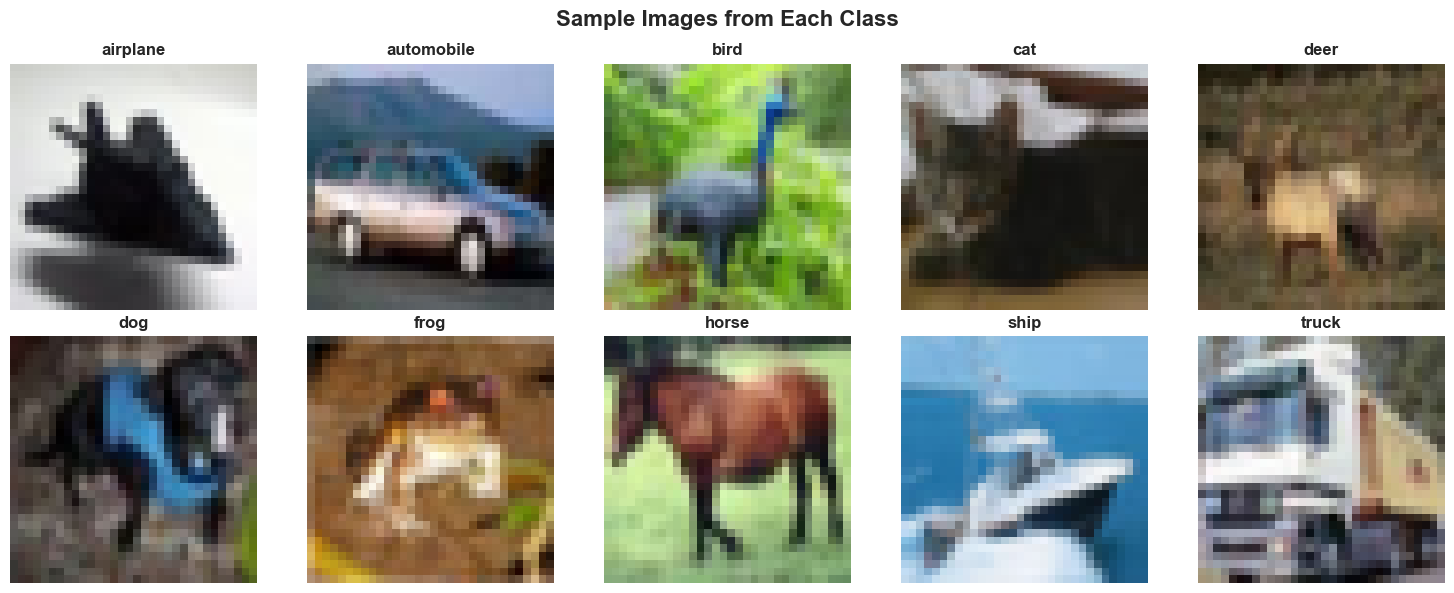


 Saved: visualization_sample_images.png


In [43]:
# 3. EXPLORATORY DATA ANALYSIS

# Visualization 1: Sample Images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    # Get first image of each class
    idx = np.where(y_train == i)[0][0]
    ax.imshow(X_train[idx])
    ax.set_title(f'{class_names[i]}', fontsize=12, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.savefig('visualization_sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Saved: visualization_sample_images.png")



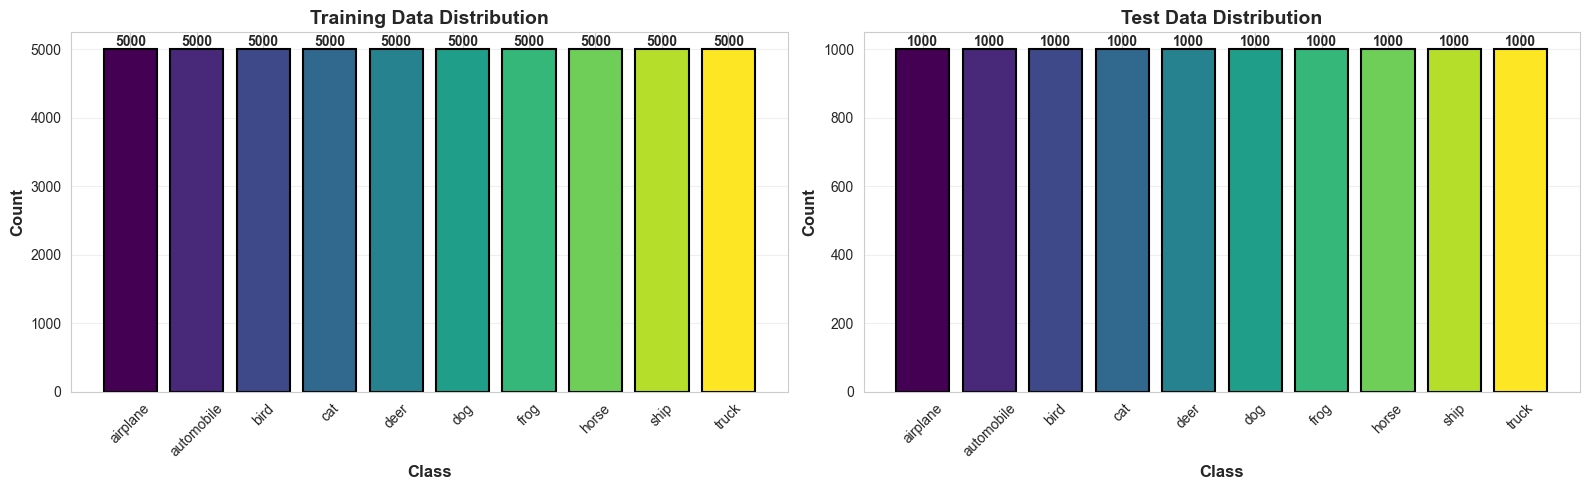

Saved: visualization_class_distribution.png

 Class Distribution Analysis:
Training samples per class: Min=5000, Max=5000
Test samples per class: Min=1000, Max=1000
 Dataset is perfectly balanced!


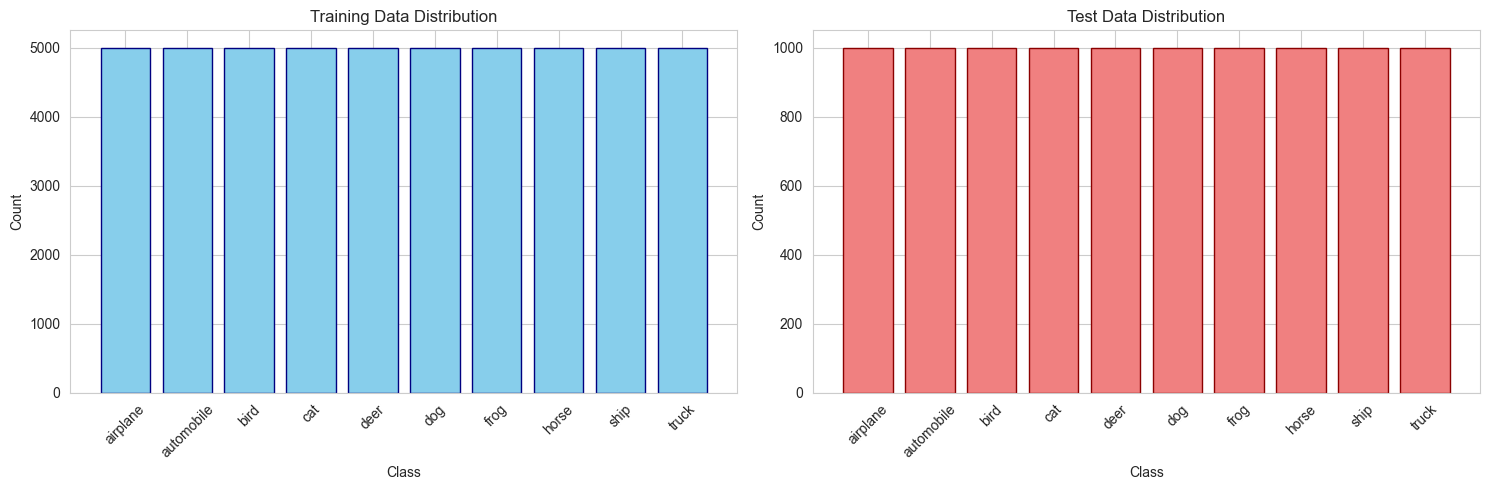

Training samples per class: [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
Test samples per class: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


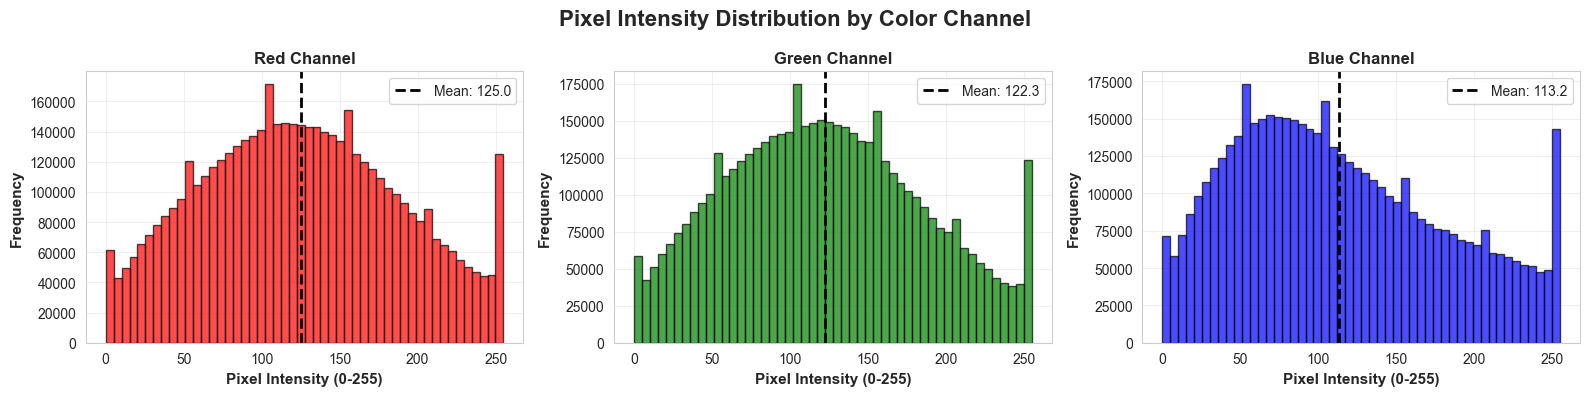

 Saved: visualization_pixel_intensity.png

 Pixel Intensity Analysis:
Red Channel - Mean: 125.31, Std: 62.99
Green Channel - Mean: 122.95, Std: 62.09
Blue Channel - Mean: 113.87, Std: 66.70


In [44]:
# Class Distribution Analysis

# Visualization 2: Class Distribution
train_counts = np.bincount(y_train.flatten())
test_counts = np.bincount(y_test.flatten())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Training distribution
colors = plt.cm.viridis(np.linspace(0, 1, 10))
bars1 = ax1.bar(class_names, train_counts, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Class', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
ax1.set_title('Training Data Distribution', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# Test distribution
bars2 = ax2.bar(class_names, test_counts, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Class', fontsize=12, fontweight='bold')
ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
ax2.set_title('Test Data Distribution', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('visualization_class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: visualization_class_distribution.png")
print("\n Class Distribution Analysis:")
print(f"Training samples per class: Min={train_counts.min()}, Max={train_counts.max()}")
print(f"Test samples per class: Min={test_counts.min()}, Max={test_counts.max()}")
print(" Dataset is perfectly balanced!")
# Visualization 2: Class Distribution
train_class_counts = np.bincount(y_train.flatten())
test_class_counts = np.bincount(y_test.flatten())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training distribution
ax1.bar(class_names, train_class_counts, color='skyblue', edgecolor='navy')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_title('Training Data Distribution')
ax1.tick_params(axis='x', rotation=45)

# Test distribution
ax2.bar(class_names, test_class_counts, color='lightcoral', edgecolor='darkred')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_title('Test Data Distribution')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Training samples per class: {train_class_counts}")
print(f"Test samples per class: {test_class_counts}")

#Pixel Intensity Analysis

# Visualization 3: Pixel Intensity Distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('Pixel Intensity Distribution by Color Channel', fontsize=16, fontweight='bold')

colors_channels = ['red', 'green', 'blue']
channel_names = ['Red Channel', 'Green Channel', 'Blue Channel']

# Sample 5000 images for analysis
sample_size = 5000
sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
X_sample = X_train[sample_indices]

for i, (ax, color, name) in enumerate(zip(axes, colors_channels, channel_names)):
    channel_data = X_sample[:, :, :, i].flatten()
    
    ax.hist(channel_data, bins=50, color=color, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Pixel Intensity (0-255)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    mean_val = np.mean(channel_data)
    ax.axvline(mean_val, color='black', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
    ax.legend()

plt.tight_layout()
plt.savefig('visualization_pixel_intensity.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Saved: visualization_pixel_intensity.png")
print("\n Pixel Intensity Analysis:")
for i, name in enumerate(['Red', 'Green', 'Blue']):
    channel_mean = np.mean(X_train[:, :, :, i])
    channel_std = np.std(X_train[:, :, :, i])
    print(f"{name} Channel - Mean: {channel_mean:.2f}, Std: {channel_std:.2f}")




In [45]:
# DATA PREPROCESSING

print("\n" + "=" * 60)
print("DATA PREPROCESSING")
print("=" * 60)

# Normalize pixel values to [0, 1]
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

print(f"\nOriginal data range: [{X_train.min()}, {X_train.max()}]")
print(f"Normalized data range: [{X_train_normalized.min():.2f}, {X_train_normalized.max():.2f}]")

# Convert labels to categorical (one-hot encoding)
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

print(f"\nOriginal label shape: {y_train.shape}")
print(f"Categorical label shape: {y_train_cat.shape}")
print(" Labels converted to one-hot encoding")

# Data Augmentation
print("\n Configuring Data Augmentation...")
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

print(" Data augmentation configured:")
print("   - Rotation: ±15 degrees")
print("   - Shift: 10% horizontal/vertical")
print("   - Horizontal flip: Yes")
print("   - Zoom: 10%")


DATA PREPROCESSING

Original data range: [0, 255]
Normalized data range: [0.00, 1.00]

Original label shape: (50000, 1)
Categorical label shape: (50000, 10)
 Labels converted to one-hot encoding

 Configuring Data Augmentation...
 Data augmentation configured:
   - Rotation: ±15 degrees
   - Shift: 10% horizontal/vertical
   - Horizontal flip: Yes
   - Zoom: 10%


In [46]:
# MODEL CREATION 

print("\n" + "=" * 60)
print("MODEL CREATION")
print("=" * 60)

def create_model(input_shape=(32, 32, 3), num_classes=10):
    """Create improved CNN model for CIFAR-10"""
    
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        
        # Block 1
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Block 3
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        # Dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ], name='CIFAR10_CNN')
    
    return model

# Create model
model = create_model()

# Display model summary
print("\n Model Architecture:")
model.summary()

# Count parameters
total_params = model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])

print(f"\n Model Parameters:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


MODEL CREATION

 Model Architecture:


Model: "CIFAR10_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,662,730 (10.16 MB)

 Trainable params: 2,660,426 (10.15 MB)

 Non-trainable params: 2,304 (9.00 KB)


 Model Parameters:
Total parameters: 2,662,730
Trainable parameters: 2,660,426


In [47]:
# MODEL COMPILATION & CALLBACKS

print("\n" + "=" * 60)
print("MODEL COMPILATION")
print("=" * 60)

# Compile model
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled with:")
print(f"   - Optimizer: Adam (lr=0.001)")
print(f"   - Loss: Categorical Crossentropy")
print(f"   - Metrics: Accuracy")

# Setup callbacks - PUT IT HERE
os.makedirs('../models', exist_ok=True)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,  # CHANGED: Increased from 10 to 15
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        '../models/best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("\n Callbacks configured:")
print("   - Early Stopping (patience=15)")
print("   - Model Checkpoint (save best)")
print("   - Learning Rate Reduction (patience=5)")


MODEL COMPILATION
Model compiled with:
   - Optimizer: Adam (lr=0.001)
   - Loss: Categorical Crossentropy
   - Metrics: Accuracy

 Callbacks configured:
   - Early Stopping (patience=15)
   - Model Checkpoint (save best)
   - Learning Rate Reduction (patience=5)


In [48]:
# MODEL TRAINING

print("\n" + "=" * 60)
print("MODEL TRAINING")
print("=" * 60)

batch_size = 64  
epochs = 50      

print(f"\n Training Configuration:")
print(f"   - Batch size: {batch_size}")
print(f"   - Epochs: {epochs}")
print(f"   - Training samples: {len(X_train_normalized)}")
print(f"   - Validation samples: {len(X_test_normalized)}")

print("\n Starting training...")
print("=" * 60)

# Train model
history = model.fit(
    datagen.flow(X_train_normalized, y_train_cat, batch_size=batch_size),
    steps_per_epoch=len(X_train_normalized) // batch_size,
    epochs=epochs,
    validation_data=(X_test_normalized, y_test_cat),
    callbacks=callbacks,
    verbose=1
)

print("\n Training completed!")

# Save history
with open('../models/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("Training history saved")


MODEL TRAINING

 Training Configuration:
   - Batch size: 64
   - Epochs: 50
   - Training samples: 50000
   - Validation samples: 10000

 Starting training...
Epoch 1/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 914ms/step - accuracy: 0.3538 - loss: 2.0797
Epoch 1: val_accuracy improved from None to 0.55430, saving model to ../models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 758s 956ms/step - accuracy: 0.4334 - loss: 1.6913 - val_accuracy: 0.5543 - val_loss: 1.2995 - learning_rate: 0.0010
Epoch 2/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 7:57 612ms/step - accuracy: 0.6406 - loss: 1.0394

c:\Users\Hp\Documents\as\MLOP_Summative\env\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.55430 to 0.56250, saving model to ../models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.6406 - loss: 1.0394 - val_accuracy: 0.5625 - val_loss: 1.2769 - learning_rate: 0.0010
Epoch 3/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5652 - loss: 1.2169
Epoch 3: val_accuracy improved from 0.56250 to 0.63410, saving model to ../models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 942s 1s/step - accuracy: 0.5915 - loss: 1.1442 - val_accuracy: 0.6341 - val_loss: 1.0860 - learning_rate: 0.0010
Epoch 4/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 9:30 731ms/step - accuracy: 0.7969 - loss: 0.5964
Epoch 4: val_accuracy improved from 0.63410 to 0.63470, saving model to ../models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.7969 - loss: 0.5964 - val_accuracy: 0.6347 - val_loss: 1.0739 - learning_rate: 0.0010
Epoch 5/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.6509 - loss: 0.9835
Epoch 5: val_accuracy improved from 0.63470 to 0.70250, saving model to ../models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 671s 859ms/step - accuracy: 0.6559 - loss: 0.9705 - val_accuracy: 0.7025 - val_loss: 0.8616 - learning_rate: 0.0010
Epoch 6/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 10:34 813ms/step - accuracy: 0.7500 - loss: 0.8042
Epoch 6: val_accuracy improved from 0.70250 to 0.71140, saving model to ../models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.7500 - loss: 0.8042 - val_accuracy: 0.7114 - val_loss: 0.8342 - learning_rate: 0.0010
Epoch 7/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.6884 - loss: 0.8826
Epoch 7: val_accuracy improved from 0.71140 to 0.71680, saving model to ../models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 632s 809ms/step - accuracy: 0.6928 - loss: 0.8726 - val_accuracy: 0.7168 - val_loss: 0.8466 - learning_rate: 0.0010
Epoch 8/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 9:08 703ms/step - accuracy: 0.7188 - loss: 0.7704
Epoch 8: val_accuracy did not improve from 0.71680
781/781 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.7188 - loss: 0.7704 - val_accuracy: 0.7118 - val_loss: 0.8638 - learning_rate: 0.0010
Epoch 9/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - accuracy: 0.7105 - loss: 0.8305
Epoch 9: val_accuracy improved from 0.71680 to 0.73190, saving model to ../models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 682s 873ms/step - accuracy: 0.7177 - loss: 0.8086 - val_accuracy: 0.7319 - val_loss: 0.7861 - learning_rate: 0.0010
Epoch 10/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 9:33 736ms/step - accuracy: 0.7500 - loss: 0.8369
Epoch 10: val_accuracy did not improve from 0.73190
781/781 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.7500 - loss: 0.8369 - val_accuracy: 0.7115 - val_loss: 0.8547 - learning_rate: 0.0010
Epoch 11/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - accuracy: 0.7329 - loss: 0.7653
Epoch 11: val_accuracy improved from 0.73190 to 0.75460, saving model to ../models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 684s 876ms/step - accuracy: 0.7360 - loss: 0.7577 - val_accuracy: 0.7546 - val_loss: 0.7398 - learning_rate: 0.0010
Epoch 12/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 9:31 733ms/step - accuracy: 0.7500 - loss: 0.7032
Epoch 12: val_accuracy did not improve from 0.75460
781/781 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.7500 - loss: 0.7032 - val_accuracy: 0.7528 - val_loss: 0.7365 - learning_rate: 0.0010
Epoch 13/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.7491 - loss: 0.7221
Epoch 13: val_accuracy improved from 0.75460 to 0.79670, saving model to ../models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 755s 967ms/step - accuracy: 0.7493 - loss: 0.7191 - val_accuracy: 0.7967 - val_loss: 0.5916 - learning_rate: 0.0010
Epoch 14/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 17:36 1s/step - accuracy: 0.7812 - loss: 0.6607
Epoch 14: val_accuracy improved from 0.79670 to 0.79680, saving model to ../models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step - accuracy: 0.7812 - loss: 0.6607 - val_accuracy: 0.7968 - val_loss: 0.5902 - learning_rate: 0.0010
Epoch 15/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.7660 - loss: 0.6815
Epoch 15: val_accuracy did not improve from 0.79680
781/781 ━━━━━━━━━━━━━━━━━━━━ 650s 833ms/step - accuracy: 0.7646 - loss: 0.6837 - val_accuracy: 0.7595 - val_loss: 0.7005 - learning_rate: 0.0010
Epoch 16/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 9:59 768ms/step - accuracy: 0.7188 - loss: 0.7431
Epoch 16: val_accuracy did not improve from 0.79680
781/781 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - accuracy: 0.7188 - loss: 0.7431 - val_accuracy: 0.7565 - val_loss: 0.7077 - learning_rate: 0.0010
Epoch 17/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.7746 - loss: 0.6482
Epoch 17: val_accuracy improved from 0.79680 to 0.80320, saving model to ../models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 697s 892ms/step - accuracy: 0.7745 - loss: 0.6515 - val_accuracy: 0.8032 - val_loss: 0.5898 - learning_rate: 0.0010
Epoch 18/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 10:17 792ms/step - accuracy: 0.7656 - loss: 0.7412
Epoch 18: val_accuracy improved from 0.80320 to 0.80400, saving model to ../models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.7656 - loss: 0.7412 - val_accuracy: 0.8040 - val_loss: 0.5884 - learning_rate: 0.0010
Epoch 19/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.7862 - loss: 0.6176
Epoch 19: val_accuracy improved from 0.80400 to 0.80650, saving model to ../models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 676s 865ms/step - accuracy: 0.7814 - loss: 0.6301 - val_accuracy: 0.8065 - val_loss: 0.5892 - learning_rate: 0.0010
Epoch 20/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 9:06 700ms/step - accuracy: 0.7500 - loss: 0.7039
Epoch 20: val_accuracy improved from 0.80650 to 0.80900, saving model to ../models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.7500 - loss: 0.7039 - val_accuracy: 0.8090 - val_loss: 0.5852 - learning_rate: 0.0010
Epoch 21/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.7895 - loss: 0.6034
Epoch 21: val_accuracy improved from 0.80900 to 0.81790, saving model to ../models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 670s 858ms/step - accuracy: 0.7883 - loss: 0.6078 - val_accuracy: 0.8179 - val_loss: 0.5417 - learning_rate: 0.0010
Epoch 22/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 9:54 762ms/step - accuracy: 0.7656 - loss: 0.6378
Epoch 22: val_accuracy improved from 0.81790 to 0.82020, saving model to ../models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.7656 - loss: 0.6378 - val_accuracy: 0.8202 - val_loss: 0.5398 - learning_rate: 0.0010
Epoch 23/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.7965 - loss: 0.5869
Epoch 23: val_accuracy did not improve from 0.82020
781/781 ━━━━━━━━━━━━━━━━━━━━ 637s 815ms/step - accuracy: 0.7970 - loss: 0.5876 - val_accuracy: 0.7903 - val_loss: 0.6390 - learning_rate: 0.0010
Epoch 24/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 11:01 848ms/step - accuracy: 0.7656 - loss: 0.6930
Epoch 24: val_accuracy did not improve from 0.82020
781/781 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.7656 - loss: 0.6930 - val_accuracy: 0.7898 - val_loss: 0.6373 - learning_rate: 0.0010
Epoch 25/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.8064 - loss: 0.5587
Epoch 25: val_accuracy did not improve from 0.82020
781/781 ━━━━━━━━━━━━━━━━━━━━ 626s 802ms/step - accuracy: 0.8041 - loss: 0.5662 - val_accuracy: 0.7952 - val_loss: 0.6277 - learning_rate: 0.001

781/781 ━━━━━━━━━━━━━━━━━━━━ 583s 746ms/step - accuracy: 0.8266 - loss: 0.5039 - val_accuracy: 0.8457 - val_loss: 0.4616 - learning_rate: 5.0000e-04
Epoch 30/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 10:23 799ms/step - accuracy: 0.7500 - loss: 0.6687
Epoch 30: val_accuracy did not improve from 0.84570
781/781 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.7500 - loss: 0.6687 - val_accuracy: 0.8449 - val_loss: 0.4645 - learning_rate: 5.0000e-04
Epoch 31/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.8343 - loss: 0.4832
Epoch 31: val_accuracy did not improve from 0.84570
781/781 ━━━━━━━━━━━━━━━━━━━━ 543s 695ms/step - accuracy: 0.8368 - loss: 0.4755 - val_accuracy: 0.8452 - val_loss: 0.4642 - learning_rate: 5.0000e-04
Epoch 32/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 7:04 544ms/step - accuracy: 0.7812 - loss: 0.6618
Epoch 32: val_accuracy did not improve from 0.84570
781/781 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7812 - loss: 0.6618 - val_accuracy: 0.8448 - val_loss: 0.4646 - learni

781/781 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.7969 - loss: 0.4908 - val_accuracy: 0.8462 - val_loss: 0.4527 - learning_rate: 5.0000e-04
Epoch 35/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - accuracy: 0.8432 - loss: 0.4560
Epoch 35: val_accuracy improved from 0.84620 to 0.85230, saving model to ../models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 687s 880ms/step - accuracy: 0.8416 - loss: 0.4578 - val_accuracy: 0.8523 - val_loss: 0.4362 - learning_rate: 5.0000e-04
Epoch 36/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 12:07 932ms/step - accuracy: 0.8438 - loss: 0.3637
Epoch 36: val_accuracy did not improve from 0.85230
781/781 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.8438 - loss: 0.3637 - val_accuracy: 0.8522 - val_loss: 0.4387 - learning_rate: 5.0000e-04
Epoch 37/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.8447 - loss: 0.4436
Epoch 37: val_accuracy improved from 0.85230 to 0.86490, saving model to ../models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 663s 849ms/step - accuracy: 0.8451 - loss: 0.4481 - val_accuracy: 0.8649 - val_loss: 0.4062 - learning_rate: 5.0000e-04
Epoch 38/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 10:15 789ms/step - accuracy: 0.8594 - loss: 0.3189
Epoch 38: val_accuracy did not improve from 0.86490
781/781 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.8594 - loss: 0.3189 - val_accuracy: 0.8640 - val_loss: 0.4070 - learning_rate: 5.0000e-04
Epoch 39/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.8472 - loss: 0.4448
Epoch 39: val_accuracy improved from 0.86490 to 0.87170, saving model to ../models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 670s 857ms/step - accuracy: 0.8479 - loss: 0.4414 - val_accuracy: 0.8717 - val_loss: 0.3811 - learning_rate: 5.0000e-04
Epoch 40/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 9:42 747ms/step - accuracy: 0.8594 - loss: 0.4117
Epoch 40: val_accuracy did not improve from 0.87170
781/781 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.8594 - loss: 0.4117 - val_accuracy: 0.8716 - val_loss: 0.3787 - learning_rate: 5.0000e-04
Epoch 41/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.8474 - loss: 0.4379
Epoch 41: val_accuracy did not improve from 0.87170
781/781 ━━━━━━━━━━━━━━━━━━━━ 652s 835ms/step - accuracy: 0.8488 - loss: 0.4366 - val_accuracy: 0.8294 - val_loss: 0.5278 - learning_rate: 5.0000e-04
Epoch 42/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 32:38 3s/step - accuracy: 0.8750 - loss: 0.4931
Epoch 42: val_accuracy did not improve from 0.87170
781/781 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - accuracy: 0.8750 - loss: 0.4931 - val_accuracy: 0.8321 - val_loss: 0.5175 - learning_

781/781 ━━━━━━━━━━━━━━━━━━━━ 766s 979ms/step - accuracy: 0.8632 - loss: 0.3930 - val_accuracy: 0.8739 - val_loss: 0.3694 - learning_rate: 2.5000e-04
Epoch 48/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 11:48 908ms/step - accuracy: 0.9062 - loss: 0.3066
Epoch 48: val_accuracy improved from 0.87390 to 0.87510, saving model to ../models/best_model.h5


781/781 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step - accuracy: 0.9062 - loss: 0.3066 - val_accuracy: 0.8751 - val_loss: 0.3698 - learning_rate: 2.5000e-04
Epoch 49/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.8643 - loss: 0.3891
Epoch 49: val_accuracy did not improve from 0.87510
781/781 ━━━━━━━━━━━━━━━━━━━━ 639s 818ms/step - accuracy: 0.8655 - loss: 0.3853 - val_accuracy: 0.8702 - val_loss: 0.3855 - learning_rate: 2.5000e-04
Epoch 50/50
  1/781 ━━━━━━━━━━━━━━━━━━━━ 9:42 746ms/step - accuracy: 0.9219 - loss: 0.3424
Epoch 50: val_accuracy did not improve from 0.87510
781/781 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.9219 - loss: 0.3424 - val_accuracy: 0.8702 - val_loss: 0.3856 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 47.

 Training completed!
Training history saved



TRAINING VISUALIZATION


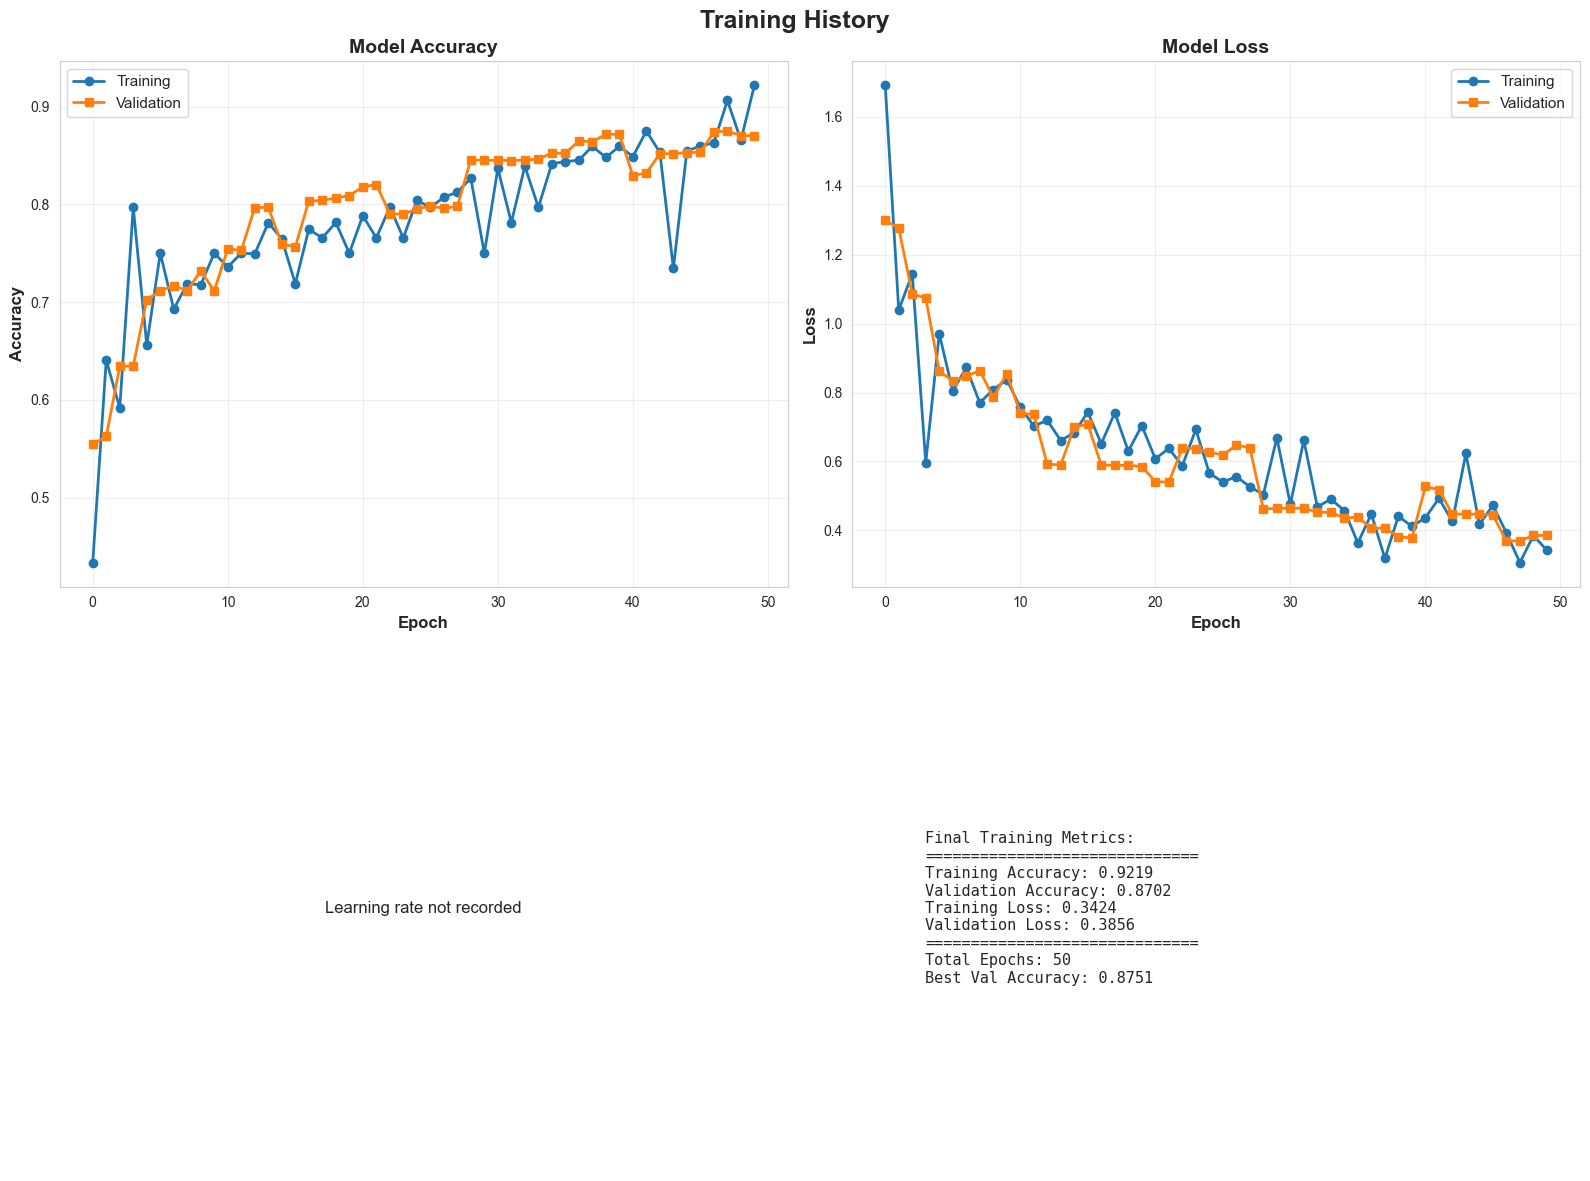

 Saved: training_history.png


In [49]:
# TRAINING VISUALIZATION

print("\n" + "=" * 60)
print("TRAINING VISUALIZATION")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Training History', fontsize=18, fontweight='bold')

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training', linewidth=2, marker='o')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2, marker='s')
axes[0, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Training', linewidth=2, marker='o')
axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2, marker='s')
axes[0, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Learning rate
if 'lr' in history.history:
    axes[1, 0].plot(history.history['lr'], linewidth=2, marker='o', color='orange')
    axes[1, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'Learning rate not recorded', 
                    ha='center', va='center', fontsize=12)
    axes[1, 0].axis('off')

# Training summary
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

summary_text = f"""
Final Training Metrics:
{'='*30}
Training Accuracy: {final_train_acc:.4f}
Validation Accuracy: {final_val_acc:.4f}
Training Loss: {final_train_loss:.4f}
Validation Loss: {final_val_loss:.4f}
{'='*30}
Total Epochs: {len(history.history['accuracy'])}
Best Val Accuracy: {max(history.history['val_accuracy']):.4f}
"""

axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                verticalalignment='center')
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Saved: training_history.png")


=== MODEL EVALUATION ===

 Making predictions on test set...
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 84ms/step

FINAL MODEL PERFORMANCE METRICS
Accuracy:  0.8739 (87.39%)
Precision: 0.8756 (87.56%)
Recall:    0.8739 (87.39%)
F1-Score:  0.8725 (87.25%)

 Detailed Classification Report:
              precision    recall  f1-score   support

    airplane       0.89      0.91      0.90      1000
  automobile       0.94      0.95      0.95      1000
        bird       0.85      0.81      0.83      1000
         cat       0.80      0.72      0.76      1000
        deer       0.87      0.84      0.86      1000
         dog       0.89      0.73      0.80      1000
        frog       0.77      0.96      0.86      1000
       horse       0.89      0.92      0.91      1000
        ship       0.94      0.94      0.94      1000
       truck       0.92      0.94      0.93      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg    

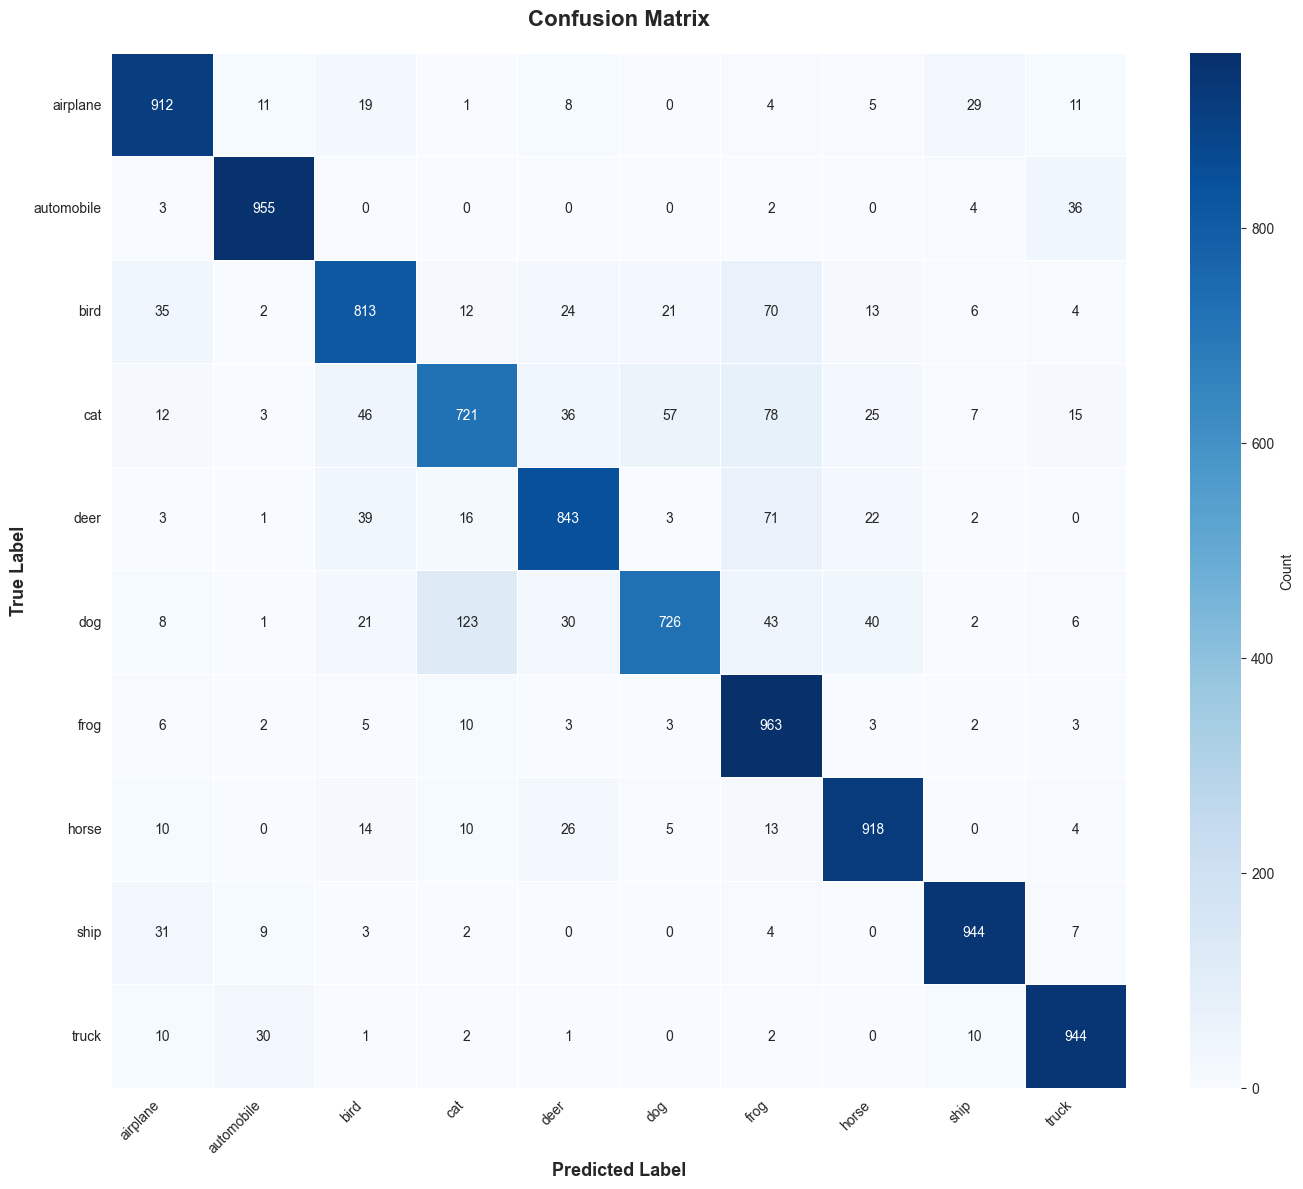

 Saved: confusion_matrix.png


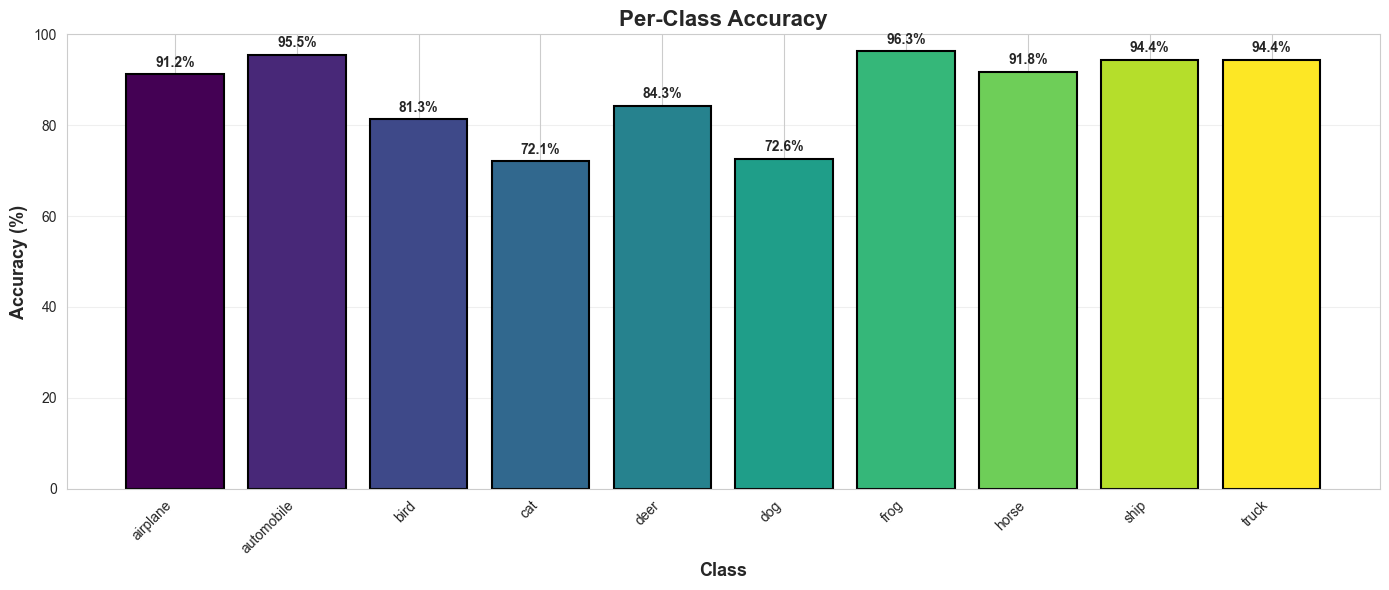

Saved: per_class_accuracy.png

 Per-Class Performance:
airplane    : 91.20%
automobile  : 95.50%
bird        : 81.30%
cat         : 72.10%
deer        : 84.30%
dog         : 72.60%
frog        : 96.30%
horse       : 91.80%
ship        : 94.40%
truck       : 94.40%


In [50]:
# MODEL EVALUATION

print("\n=== MODEL EVALUATION ===")

# Make predictions
print("\n Making predictions on test set...")
y_pred_probs = model.predict(X_test_normalized)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test.flatten()

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\n" + "=" * 60)
print("FINAL MODEL PERFORMANCE METRICS")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print("=" * 60)

# Detailed classification report
print("\n Detailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

#  Confusion Matrix
print("\n Creating Confusion Matrix...")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'}, linewidths=0.5)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Saved: confusion_matrix.png")

# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(14, 6))
bars = plt.bar(class_names, class_accuracy * 100, 
               color=plt.cm.viridis(np.linspace(0, 1, 10)),
               edgecolor='black', linewidth=1.5)
plt.xlabel('Class', fontsize=13, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
plt.title('Per-Class Accuracy', fontsize=16, fontweight='bold')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, acc in zip(bars, class_accuracy):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{acc*100:.1f}%', ha='center', va='bottom', 
             fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('per_class_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: per_class_accuracy.png")

print("\n Per-Class Performance:")
for i, name in enumerate(class_names):
    print(f"{name:12s}: {class_accuracy[i]*100:.2f}%")

In [51]:
# SAVE MODEL 

print("\n" + "=" * 60)
print("SAVING MODEL")
print("=" * 60)

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save in H5 format (this is enough for the project)
model_h5_path = '../models/cifar10_classifier.h5'
model.save(model_h5_path)
print(f"Saved H5 model: {model_h5_path}")

# Save metadata
metadata = {
    'class_names': class_names,
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'input_shape': (32, 32, 3),
    'num_classes': 10,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_params': int(total_params),
    'trainable_params': int(trainable_params)
}

with open('../models/model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("Saved model metadata")

print("\n Files created:")
print(f"   - {model_h5_path}")
print(f"   - ../models/model_metadata.pkl")
print(f"   - ../models/training_history.pkl")


SAVING MODEL
Saved H5 model: ../models/cifar10_classifier.h5
Saved model metadata

 Files created:
   - ../models/cifar10_classifier.h5
   - ../models/model_metadata.pkl
   - ../models/training_history.pkl



TESTING PREDICTION FUNCTION

 Testing predictions on random test images:



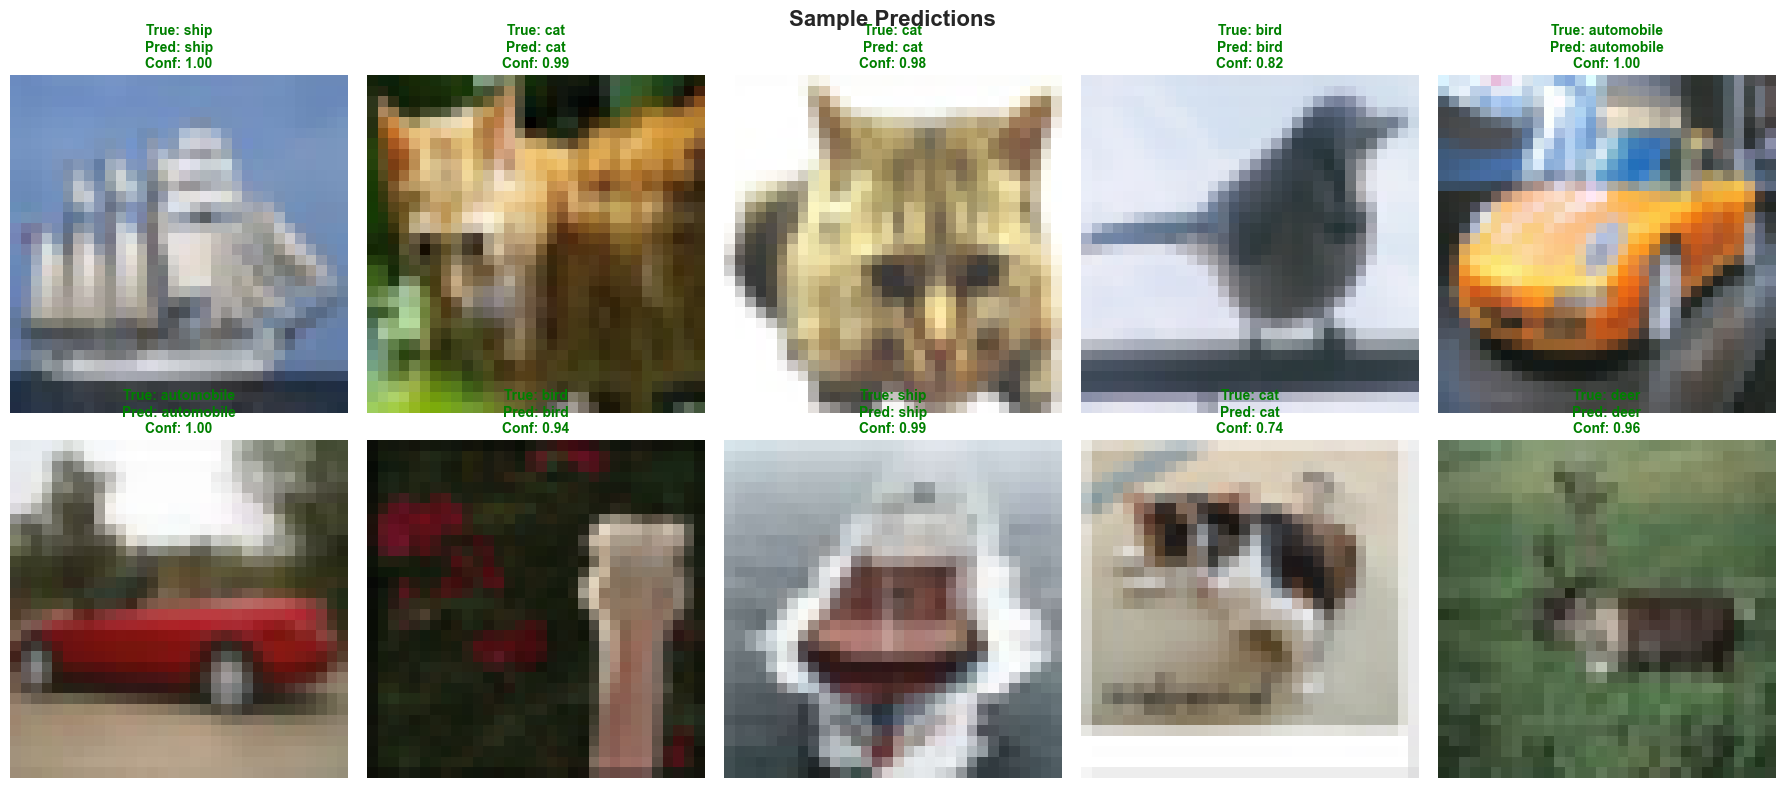

 Saved: sample_predictions.png

 Final Results:
   - Accuracy: 87.39%
   - Precision: 87.56%
   - Recall: 87.39%
   - F1-Score: 87.25%


In [52]:
# TEST PREDICTION FUNCTION

print("\n" + "=" * 60)
print("TESTING PREDICTION FUNCTION")
print("=" * 60)

def predict_image(model, image, class_names):
    """Predict class of a single image"""
    if image.shape != (32, 32, 3):
        raise ValueError(f"Image must be (32,32,3), got {image.shape}")
    
    image_batch = np.expand_dims(image, axis=0)
    predictions = model.predict(image_batch, verbose=0)
    
    predicted_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_idx]
    
    all_predictions = [
        {'class': class_names[i], 'confidence': float(predictions[0][i])}
        for i in range(len(class_names))
    ]
    all_predictions.sort(key=lambda x: x['confidence'], reverse=True)
    
    return {
        'predicted_class': class_names[predicted_idx],
        'confidence': float(confidence),
        'all_predictions': all_predictions
    }

# Test on random images
print("\n Testing predictions on random test images:\n")

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
fig.suptitle('Sample Predictions', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(X_test_normalized))
    test_image = X_test_normalized[idx]
    true_label = class_names[y_test[idx][0]]
    
    result = predict_image(model, test_image, class_names)
    pred_label = result['predicted_class']
    confidence = result['confidence']
    
    ax.imshow(X_test[idx])
    
    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}',
                 fontsize=10, color=color, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Saved: sample_predictions.png")

print("\n Final Results:")
print(f"   - Accuracy: {accuracy*100:.2f}%")
print(f"   - Precision: {precision*100:.2f}%")
print(f"   - Recall: {recall*100:.2f}%")
print(f"   - F1-Score: {f1*100:.2f}%")
